In [2]:
FRICTION_CATEGORIES = [
    'Probing',
    'Overspecification',
    'Not Friction', 
    'Assumption Reveal', 
    'Reinforcement', 
    'Reflective Pause'
]

class Friction:

    with open('system.txt', 'r') as txt:
        system = '\n'.join(txt.readlines())

    def prompt(x):
        p = f'The dialogue context is provided next.\n\n{x["context"]}\n\n\n'
        try:
            p += f'The response is provided below.\n\nResponse: {x["response"]}\n\n\n'
        except KeyError:
            p += f'The response is provided below.\n\nResponse: \n\n\n'
        p += 'What friction category if any?'
        return p

f = Friction()

In [3]:
from convokit import Corpus, download
corpus = Corpus(download('persuasionforgood-corpus'))

/home/tejas/anaconda3/envs/hai/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Dataset already exists at /home/tejas/.convokit/downloads/persuasionforgood-corpus


In [4]:
import numpy as np

all_acts = []
for c in corpus.conversations.values():
    if c.meta['is_annotated']:
        for u in c._utterance_ids:
            if type(corpus.utterances[u].meta['label_1']) == list and corpus.utterances[u].meta['role'] == 0:
                acts = list(set(corpus.utterances[u].meta['label_1']))
                all_acts.extend(acts)
unique_acts = list(set(all_acts))
print(len(unique_acts))
print(unique_acts)

27
['ask-donate-more', 'task-related-inquiry', 'you-are-welcome', 'ask-donation-amount', 'source-related-inquiry', 'donation-information', 'closing', 'other', 'comment-partner', 'logical-appeal', 'foot-in-the-door', 'confirm-donation', 'negative-to-inquiry', 'praise-user', 'personal-story', 'thank', 'greeting', 'positive-to-inquiry', 'neutral-to-inquiry', 'emotion-appeal', 'ask-not-donate-reason', 'off-task', 'personal-related-inquiry', 'self-modeling', 'credibility-appeal', 'acknowledgement', 'proposition-of-donation']


In [5]:
from collections import defaultdict

act2utterances = defaultdict(list)
for c in corpus.conversations.values():
    if c.meta['is_annotated']:
        for u in c._utterance_ids:
            if type(corpus.utterances[u].meta['label_1']) == list and corpus.utterances[u].meta['role'] == 0:
                conv = corpus.utterances[u].get_conversation()
                if conv.get_utterance_ids().index(u) < 3:
                    continue
                acts = list(set(corpus.utterances[u].meta['label_1']))
                for act in acts:
                    act2utterances[act].append(corpus.utterances[u])

In [5]:
for act in unique_acts:
    print(act, len(act2utterances[act]))
selected_acts = [a for a in unique_acts if len(act2utterances[a]) > 50]

selected_acts = [
    'logical-appeal',
    'emotion-appeal',
    'credibility-appeal',
    'foot-in-the-door',
    'self-modeling',
    'personal-story',
    'donation-information',
    'source-related-inquiry',
    'task-related-inquiry',
    'personal-related-inquiry',
]
print(f"Selected {len(selected_acts)} acts with more than 50 utterances")

credibility-appeal 445
task-related-inquiry 108
greeting 3
praise-user 113
positive-to-inquiry 53
logical-appeal 222
thank 204
emotion-appeal 144
you-are-welcome 7
confirm-donation 41
ask-donation-amount 95
source-related-inquiry 38
personal-story 65
proposition-of-donation 164
foot-in-the-door 100
comment-partner 14
negative-to-inquiry 21
donation-information 273
ask-donate-more 29
neutral-to-inquiry 18
closing 54
personal-related-inquiry 74
ask-not-donate-reason 3
other 269
self-modeling 112
off-task 61
acknowledgement 205
Selected 10 acts with more than 50 utterances


In [6]:
act = "personal-story"
for u in act2utterances[act][:10]:
    print(u.text, u.meta['label_1'])
    print()

Oh yeah.  When I first heard about these super well known organizations only actually using about 5% of their proceeds for their services I was shocked.  Save the Children uses a total of 86% of proceeds for their services and programs! The rest goes to "fundraising, management, and general" as the website says.  That\'s good to hear that it\'s not all about filling some people\'s pockets. ['other', 'personal-story', 'credibility-appeal', 'credibility-appeal', 'logical-appeal']

My friend had refer me. She volunteers for them. Would you be interested in donating some of your earnings today to Save the Children? The research team is collecting donations. ['personal-story', 'personal-story', 'proposition-of-donation', 'donation-information']

It's a very rewarding experience. A productive activity to fill your free time with. :) ['personal-story', 'personal-story', 'other']

I see children everyday even in my community who do not have enough to eat and they are not able to afford to go t

In [6]:
def get_conversation_context(utterance):
    conv = utterance.get_conversation()
    uids = conv.get_utterance_ids()
    context = ""
    for u in uids:
        if u == utterance.id:
            break
        context += f"Speaker {corpus.utterances[u].meta['role']+1}: {corpus.utterances[u].text}\n"
    return context

def get_act_specific_utterance(utterance, act):
    sentences = utterance.meta['text_by_sent'].split('<s>')
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    assert len(sentences) == len(utterance.meta['label_1'])
    selected_sentences =[s for s, l in zip(sentences, utterance.meta['label_1']) if l == act]
    return ' '.join(selected_sentences)

u = act2utterances[act][0]
print(f"Context:\n{get_conversation_context(u)}")
print(f"Response:\nSpeaker {u.meta['role']+1}: {get_act_specific_utterance(u, act)}\n")

Context:
Speaker 1: Have you heard of the charity Save the Children?
Speaker 2: Yes I have, but I don't know a lot about it.
Speaker 1: They promote children's rights, provides relief, and helps support children in developing countries.
Speaker 2: That sounds like a very nice cause.

Response:
Speaker 1: Yes, it\'s a great cause.



In [9]:
import random

prepared_data = []
for act in selected_acts:
    random.shuffle(act2utterances[act])
    for u in act2utterances[act][:50]:
        context = get_conversation_context(u)
        #response = f"Speaker {u.meta['role']+1}: {u.text}\n"
        response = f"Speaker {u.meta['role']+1}: {get_act_specific_utterance(u, act)}\n"
        #new_d = {"context": context, "response": response, "dialogue_acts": u.meta['label_1']}
        new_d = {"context": context, "response": response, "dialogue_acts": [act]}
        prepared_data.append(new_d)
print(f"Selected {len(prepared_data)} examples for annotation")

Selected 488 examples for annotation


In [10]:
import random
from openai_utils import openai_caller

idx = random.choice(range(len(prepared_data)))
d = prepared_data[idx]
print(f"Context: {d['context']}")
print(f"Response: {d['response']}")
print(f"Dialog acts: {d['dialogue_acts']}")

prompt = Friction.system + Friction.prompt(d)
messages = [{'role': 'system', 'content': prompt}]

gpt_response = openai_caller(messages, max_new_tokens=256, model='gpt4o')
print(f"ANNOTATION:\n{gpt_response}")

Context: Speaker 1: Would you like to donate to a Charity called Save the Children?
Speaker 2: Hi, it all depends on who you really are, if it's for a person very close to me if I'm willing
Speaker 1: It would go to supporting children in developing countries, especially in war zones. For instance, millions of Syrian children have grown up facing the daily threat of violence. In the first two months of 2018 alone, 1,000 children were reportedly killed or injured in intensifying violence. 
Speaker 2: if I would agree with that, and if my organ donated what problems would my body have? the operation has risks
Speaker 1: I am not asking for an organ donation, but more of a financial one. You can give any amount, even as little as $0.01 can help.
Speaker 2: oh ok I'm sorry I have read wrong, if I would be willing to donate with pleasure is a good cause
Speaker 1: How much would you like to donate?
Speaker 2: I am willing to donate $ 10
Speaker 1: Fantastic, you are a very generous person a

In [11]:
openai_caller.compute_cost()

0.0038725

In [104]:
from tqdm import tqdm

openai_caller.reset_tokens_used()
annotated_data = []

for d in tqdm(prepared_data, desc=f"Cost: ${openai_caller.compute_cost():.4f}"):
        prompt = Friction.system + Friction.prompt(d)
        messages = [{'role': 'system', 'content': prompt}]
        gpt_response = openai_caller(messages, max_new_tokens=256, model='gpt4o')
        friction_anno = gpt_response.split('ANSWER = ')[-1]
        new_d = d.copy()
        new_d['friction_anno'] = friction_anno
        new_d['gpt_response'] = gpt_response
        annotated_data.append(new_d)
print(f"Annotation cost: ${openai_caller.compute_cost():.4f}")

Cost: $0.0000: 100%|██████████| 488/488 [15:51<00:00,  1.95s/it]

Annotation cost: $2.1733


In [7]:
import json

annotated_data = json.load(open('/home/tejas/projects/becareful_friction_anno/data/persuasionforgood_anno-488instances.json'))

In [8]:
from collections import Counter
annotations = [x['friction_anno'] for x in annotated_data]
print(Counter(annotations))

Counter({'Overspecification': 158, 'Probing': 145, 'Not Friction': 110, 'Assumption Reveal': 42, 'Reinforcement': 28, 'Reflective Pause': 3, 'Not Friction.': 1, 'Let\'s analyze the response given by Speaker 1: "Vulnerable children in poverty. Denied an education. Forced to flee violence. Orphaned, abused, abandoned. Children with no reason to smile. No hope for the future."\n\n1. **Assumption Reveal**: The response does not reveal any assumptions or beliefs about the environment, conversation, or interlocutors.\n\n2. **Reflective Pause**: There is no pause, reflection, or change in the course of action depicted in the response.\n\n3. **Reinforcement**: The response does not restate a previous utterance for emphasis.\n\n4. **Overspecification**: The response does provide detailed information about the situation of vulnerable children, but this information is not necessarily self-evident or observable by other means in the conversation.\n\n5. **Probing**: The response does not pose any q

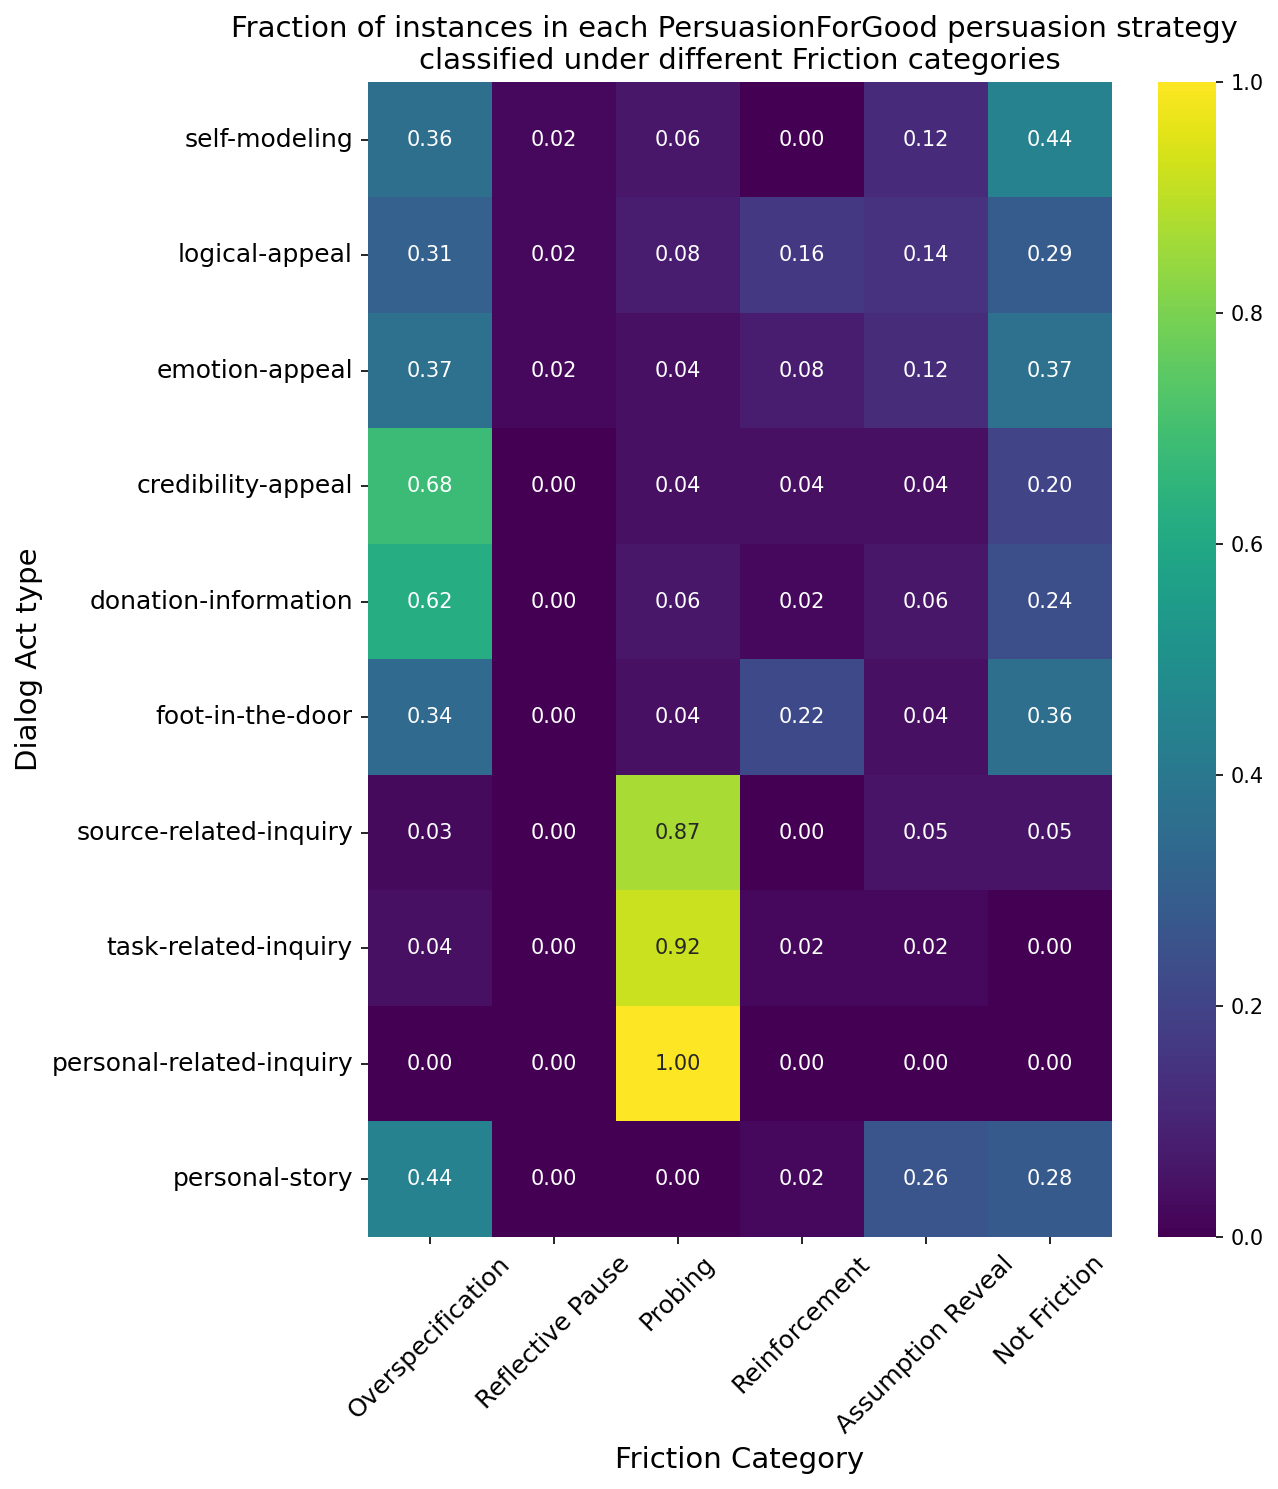

In [10]:
from collections import Counter

acttype_frictionanno_counter = Counter()
for d in annotated_data:
    for a in set(d['dialogue_acts']):
        if a in selected_acts and d['friction_anno'] in FRICTION_CATEGORIES:
            acttype_frictionanno_counter[(a, d['friction_anno'])] += 1

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rows = list(set([x[0] for x in acttype_frictionanno_counter.keys()]))
rows.sort(key=lambda x: x[::-1])
cols = set([x[1] for x in acttype_frictionanno_counter.keys()])
data = [[acttype_frictionanno_counter[(r, c)]/sum([acttype_frictionanno_counter[(r, c2)] for c2 in cols]) for c in cols] for r in rows]
df = pd.DataFrame(data)#, index=rows, columns=cols)
plt.figure(figsize=(8, 10), dpi=150)
sns.heatmap(df, annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('Friction Category', fontsize=14)
plt.ylabel('Dialog Act type', fontsize=14)
plt.xticks(ticks=[x+0.5 for x in range(len(cols))], labels=cols, rotation=45, fontsize=12)
plt.yticks(ticks=[x+0.5 for x in range(len(rows))], labels=rows, rotation=0, fontsize=12)
plt.title('Fraction of instances in each PersuasionForGood persuasion strategy \nclassified under different Friction categories', fontsize=14)
plt.show()

In [1]:
rows
for r in rows:
    print(r, sum([acttype_frictionanno_counter[(r, c)] for c in cols]))

NameError: name 'rows' is not defined

In [114]:
import json
json.dump(annotated_data, open(f'data/persuasionforgood_anno-{len(annotated_data)}instances.json', 'w'), indent=2)